In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import cdsapi
import glob
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import regionmask 

In [12]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'
gis_folder = f'{home_path}\\GIS'

In [13]:
# loading other layers
outline           = gpd.read_file(f"{gis_folder}\\hudson_basin_26918.gpkg",driver="GPKG",crs="EPSG:26918") 
outline_buffered  = gpd.read_file(f"{gis_folder}\\hudson_basin_buffered.gpkg",crs="EPSG:26918")

# fixing crs
for layer in [outline,outline_buffered]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

# Prepare data
limit to 2010-2015 due to storage constraints

## P
ERA 5 obtained form ESMValTool - Forcings for the HBVmountain hydrological model: *with thanks to Rolf Hut*

In [25]:
ds_era5 = xr.load_dataset(f"{data_folder}\\ERA5_Group18_2010_2015.nc")

In [26]:
mask = regionmask.mask_geopandas(outline_buffered, 
                                 ds_era5['pr'].lon.to_numpy(), 
                                 ds_era5['pr'].lat.to_numpy(),
                                 lon_name="lon",
                                 lat_name="lat")

In [37]:
cropped_ds_era5 = ds_era5.where(mask==0)

Pr in "kg m-2 s-1" -> *86400 mm/d

In [47]:
pr_series = cropped_ds_era5["pr"].mean(dim=["lat","lon"]).to_pandas() * 86400 
df_era5_P = pd.DataFrame(pr_series,columns=["pr"])

IMERGE from [google earth engine](https://developers.google.com/earth-engine/datasets/catalog/NASA_GPM_L3_IMERG_V06) with thanks to clear explanations by the [intro guide.](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api)

In [7]:
IMERGE = pd.read_parquet(f"{data_folder}\\P\\IMERG.parquet")

Load precipitation data from stations

In [69]:
files = glob.glob(f"{data_folder}\\combined*.parquet")
df_all_data = pd.read_parquet(files[0]).loc["2010":"2015"]
station_data = df_all_data[["P"]]

Comparison:

(14610.0, 16436.0)

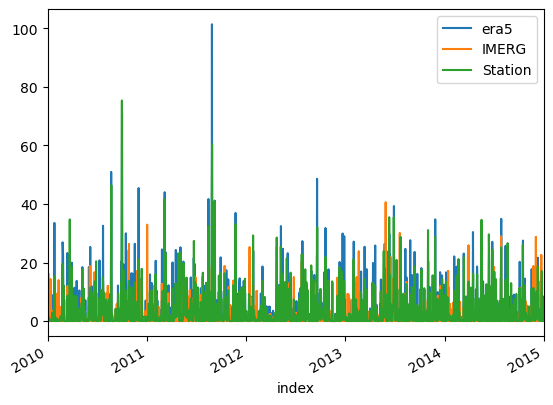

In [68]:
fig, ax = plt.subplots(1)
df_era5_P["pr"].plot(ax=ax,label="era5")
IMERGE["P"].plot(ax=ax,label="IMERG")
station_data["P"].plot(ax=ax,label="Station")
ax.legend()
ax.set_xlim(("2010","2015"))

## E 
Load in EP from data collected already

In [81]:
ERA5_E = df_all_data[["Pev"]]

In [104]:
MODIS = pd.read_parquet(f"{data_folder}\\EP\\MODIS.parquet").dropna()
MODIS["PET"] = MODIS["PET"] * 0.1

"kg/m^2/8day"  -> mm: scale factor 0.1

In [112]:
MODIS_monthly = MODIS.resample('m').sum()

In [121]:
GLEAM = pd.read_parquet(f"{data_folder}\\EP\\GLEAM.parquet")

KeyError: 'PET'

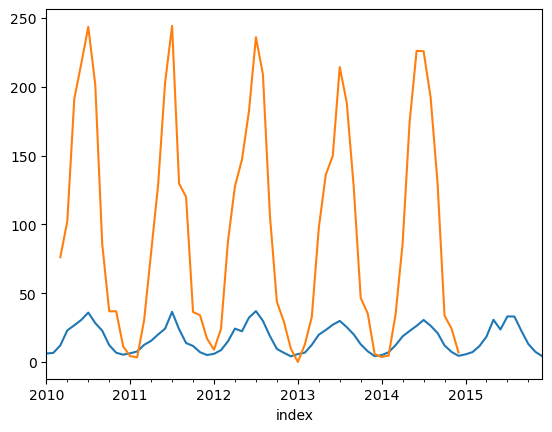

In [123]:
fig, ax = plt.subplots(1)
ERA5_E["Pev"].resample("M").sum().plot(ax=ax,label="Era5E")
MODIS_monthly["PET"].plot(ax=ax,label="MODIS")
GLEAM["PET"].plot(ax=ax,label="GLEAM")